In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
tsp_data_txt = open('tsp_dataset.txt')

In [3]:
lines = tsp_data_txt.readlines()

In [4]:
tsp_data_txt = open('tsp_dataset.txt')
data = {}
lines = tsp_data_txt.readlines()
distance_matrix = np.zeros((len(lines),len(lines)))
for i,line in enumerate(lines):
    for j,element in enumerate((line.split('\n')[0].split('       '))):
        if(element == ''):
            continue
        
        distance_matrix[i][j-1] = int(element.strip())
data['distance_matrix']= distance_matrix
data['reward_matrix'] = [1 for i  in range(0,len(distance_matrix))]
data['depot'] = 0
data['n_state'] = sum(list(range(1,len(distance_matrix))))
data['n_action'] = len(distance_matrix)
data['visited_nodes'] = []


In [5]:
for i in range(0,len(data['distance_matrix'])):
    data['distance_matrix'][i][i] = 9999


In [6]:
def change_reward(envp):
    for i in range(0,envp['n_state']):
        for j in range(0,envp['n_action']):
            for k in range(0,envp['n_action']):
                if k==0:
                    env['P'][i][j][k][2]= 10
                    env['P'][i][j][k][3]= True
                    break
    return envp

In [7]:
def initialze_value(env):
    initial_P = 1/(env['n_action']-1)
    env['P'] = {}
    
    #P[state][action] = [(prob, next state, reward, done), ...]
    
    for i in range(0,env['n_state']):
        env['P'][i] ={}
        
        if(i==104):
            for j in range(0,env['n_action']):
                env['P'][i][j] = []
                initial_P = 1/(env['n_action']-1)
                for k in range(0,env['n_action']):
                    if (j == env['depot'] and k == env['depot']):
                        ini_temp = [1,k,10,True]
                        env['P'][i][j].append(ini_temp)
                        initial_P = 0
                        continue
                    ini_temp = [initial_P,k,data['reward_matrix'][k],False]
                    env['P'][i][j].append(ini_temp)
        else:
            for j in range(0,env['n_action']):
                env['P'][i][j] = []
                for k in range(0,env['n_action']):
                    ini_temp = [initial_P,k,data['reward_matrix'][k],False]
                    env['P'][i][j].append(ini_temp)
    
    env['state'] = []
    for si in range(0,env['n_state']):
        env['state'].append([])
        for n in range(0,env['n_action']):
            env['state'][si].append(initial_P)
    
    env['state'] = np.asarray(env['state']).reshape((env['n_action'],-1))
            
    return env
    

In [8]:
# Hyperparameters
learning_rate = 0.0002
gamma         = 0.98

# Run configurations
print_every = 100
num_episodes = 100000

In [9]:
class ActorCritic(nn.Module):
    def __init__(self, n_state, n_action):
        super(ActorCritic, self).__init__()
        self.shared_layer = nn.Linear(n_state,256)
        self.policy_layer = nn.Linear(256,n_action)
        self.value_layer = nn.Linear(256,n_action)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.data = []
        
    def get_action_with_softmax(self,prob):
        visited_index = []
        prob[0][0] =  torch.tensor(float('-inf'))
        first_index = Categorical(F.softmax(prob[0][:15])).sample()
       
        visited_index.append(first_index)
        for pi,pb in enumerate(prob[1:]):    
            if pi <13:
                prob[pi+1][0] =  torch.tensor(float('-inf'))
            for vi,viv in enumerate(visited_index):
                prob[pi+1][viv] =  torch.tensor(float('-inf'))
            temp_index = Categorical(F.softmax(prob[pi+1][:15])).sample()
            visited_index.append(temp_index)
        return visited_index,F.softmax(prob)
    
    def policy(self, state):
        x = F.relu(self.shared_layer(state))
        x = self.policy_layer(x)
        return x
    
    def get_action(self, state):
        prob = self.policy(torch.from_numpy(state).float())
        return prob
      
    
    def value(self, state):
        x = F.relu(self.shared_layer(state.float()).float()).float()
        value = self.value_layer(x).float()
        return value
    
    def save(self, transition):
        self.data.append(transition)
        
    
    def get_policy_action(self,state):
        prob = self.policy(torch.from_numpy(state).float())
        action,sprob = self.get_action_with_softmax(prob)

        return action,state,prob,self.get_reward(action)

    def get_reward(self,visit_list):
        depot =0
        distance = torch.tensor(data['distance_matrix'])[0][visit_list[0]]
        prev_cite = visit_list[0]
        for i in range(1,14):
            distance+= torch.tensor(data['distance_matrix'])[prev_cite][visit_list[i]]
            prev_cite =visit_list[i]

        distance+= torch.tensor(data['distance_matrix'])[prev_cite][visit_list[14]]
        return distance
    
    def update(self):
        action,state, prob,reward = self.data.pop()
        self.value(torch.tensor(env['state']).float())
        td_target = reward - self.value(torch.tensor(env['state']).float())
        td_error = td_target - self.value(torch.tensor(env['state']).float())
        
        dist = self.policy(torch.tensor(env['state']).float())

        action,sprob = self.get_action_with_softmax(dist)
        loss_actor =  sprob * td_error.detach()

        #loss_critic = F.smooth_l1_loss(self.value(torch.tensor(state)), td_target.detach()).float()
        loss_critic = (self.value(torch.tensor(env['state']).float()).detach() + td_target.detach())
        
        loss = -1*(loss_actor + loss_critic)
  
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()
        
    def get_prob_for_update(self,ction,prob):
        prob_list = torch.zeros((15,15))
        for pi,pl in enumerate(prob_list):
            prob_list[pi]+= prob[action[pi]]
        return prob_list


In [10]:
env = initialze_value(data)

In [11]:
actor_critic = ActorCritic(n_state=105, n_action=15)

In [12]:
def train(agent, env, print_every=200, num_episodes=10000, learning_rate=0.00002):
    episodic_reward = np.zeros([num_episodes])
    for n_epi in range(num_episodes):
        done = False
        state = env['state']
        action,state,sprob,reward = agent.get_policy_action(state)

        agent.save((action,state,sprob,reward))
        episodic_reward[n_epi] += reward                     
        agent.update()
        if (n_epi==0) or ((n_epi+1) % print_every == 0):
            print("# of episode :{}, return : {:.1f}".format(n_epi, episodic_reward[n_epi]))
            


In [13]:
train(actor_critic, env)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_25616/34783881.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  first_index = Categorical(F.softmax(prob[0][:15])).sample()
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_25616/34783881.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  temp_index = Categorical(F.softmax(prob[pi+1][:15])).sample()
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_25616/34783881.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return visited_index,F.softmax(prob)


# of episode :0, return : 687.0
# of episode :199, return : 613.0
# of episode :399, return : 674.0
# of episode :599, return : 634.0
# of episode :799, return : 721.0
# of episode :999, return : 706.0
# of episode :1199, return : 705.0
# of episode :1399, return : 706.0
# of episode :1599, return : 706.0
# of episode :1799, return : 690.0
# of episode :1999, return : 706.0
# of episode :2199, return : 705.0
# of episode :2399, return : 706.0
# of episode :2599, return : 705.0
# of episode :2799, return : 705.0
# of episode :2999, return : 705.0
# of episode :3199, return : 705.0
# of episode :3399, return : 705.0
# of episode :3599, return : 705.0
# of episode :3799, return : 705.0
# of episode :3999, return : 705.0
# of episode :4199, return : 705.0
# of episode :4399, return : 705.0
# of episode :4599, return : 705.0
# of episode :4799, return : 705.0
# of episode :4999, return : 705.0
# of episode :5199, return : 705.0
# of episode :5399, return : 705.0
# of episode :5599, return :

# actor_critic.get_action(state)

In [18]:
a,b =actor_critic.get_action_with_softmax(torch.tensor(env['state']))

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_25616/34783881.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  first_index = Categorical(F.softmax(prob[0][:15])).sample()
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_25616/34783881.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  temp_index = Categorical(F.softmax(prob[pi+1][:15])).sample()
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_25616/34783881.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return visited_index,F.softmax(prob)


In [21]:
[int(a_i) for a_i in a]

[2, 1, 7, 11, 6, 10, 4, 5, 14, 8, 3, 9, 13, 12, 0]

In [16]:
def visualize_map_route(data,tour_list=None):
    scaled_distance_matrix = data['distance_matrix']/100
    x_point = []
    y_point = []
    for di,dis in enumerate(scaled_distance_matrix[0]):
        if di%2 ==0 :
            x_point.append(dis-di*0.05*dis)
            y_point.append(di*0.01*dis)
        elif di%3==0:
            x_point.append(dis/2)
            y_point.append(dis/2)
        else:
            x_point.append(di*0.05*dis)
            y_point.append(dis-di*0.05*dis)
            
    plt.plot(x_point,y_point,'bo')
    plt.plot(x_point[0],y_point[0],'bo',color='red')
    line_x = []
    line_y = []
    if tour_list!=None:
        for tl in tour_list:
            line_x.append(x_point[tl])
            line_y.append(y_point[tl])
            
        plt.plot(line_x,line_y)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_25616/2649083656.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_point[0],y_point[0],'bo',color='red')


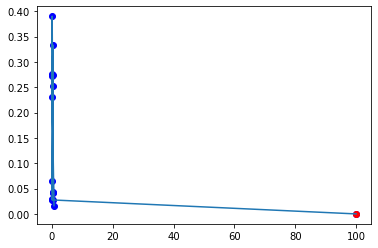

In [22]:
visualize_map_route(data,[2, 1, 7, 11, 6, 10, 4, 5, 14, 8, 3, 9, 13, 12, 0])

In [23]:
def get_reward(visit_list):
    depot =0
    distance = (data['distance_matrix'])[0][visit_list[0]]
    prev_cite = visit_list[0]
    for i in range(1,14):
        distance+= (data['distance_matrix'])[prev_cite][visit_list[i]]
        prev_cite =visit_list[i]

    distance+= (data['distance_matrix'])[prev_cite][visit_list[14]]
    return distance

In [24]:
get_reward([2, 1, 7, 11, 6, 10, 4, 5, 14, 8, 3, 9, 13, 12, 0])

745.0